In [59]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import polars as pl

Representation of Original Graph

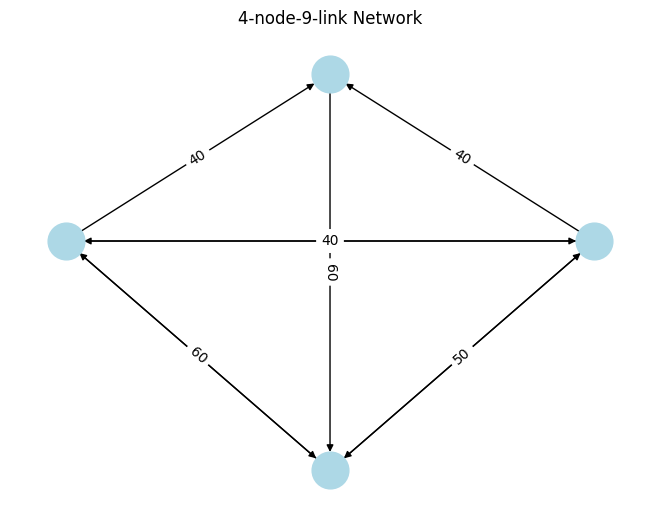

In [60]:
G = nx.DiGraph()

edges = [
    (1, 2, {'free_flow_time': 0.3, 'length': 10, 'capacity': 40}),
    (1, 3, {'free_flow_time': 0.5, 'length': 20, 'capacity': 40}),
    (2, 3, {'free_flow_time': 0.4, 'length': 20, 'capacity': 60}),
    (2, 4, {'free_flow_time': 0.4, 'length': 10, 'capacity': 40}),
    (3, 4, {'free_flow_time': 0.3, 'length': 20, 'capacity': 40}),
    (4, 1, {'free_flow_time': 1.0, 'length': 40, 'capacity': 60}),
    (2, 1, {'free_flow_time': 0.4, 'length': 15, 'capacity': 50}),
    (3, 1, {'free_flow_time': 0.4, 'length': 20, 'capacity': 60}),
    (3, 2, {'free_flow_time': 0.5, 'length': 20, 'capacity': 40})
]

G.add_edges_from(edges)

pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, with_labels=False, node_size=700, node_color="lightblue", arrows=True)
labels = {(u, v): d['capacity'] for u, v, d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)

plt.title("4-node-9-link Network")
plt.show()

# labels are half wrong in graph


changing weight of streets to cost of driving down that street

In [61]:
df = pl.DataFrame({
    "from": [u for u, v, d in edges],
    "to": [v for u, v, d in edges],
    "free_flow_time": [d["free_flow_time"] for _, _, d in edges],
    "length": [d["length"] for _, _, d in edges],
    "capacity": [d["capacity"] for _, _, d in edges],
})

#plug in traffic values
traffic = [10,20,30,40,50,60,70,80,90]
df = df.with_columns(pl.Series("traffic", traffic))

#can change to have different a,b for every street
a = 0.15
b = 4
df = df.with_columns((pl.col("free_flow_time") * (1 + a * (pl.col("traffic")/pl.col("capacity")) ** b)).alias("time"))

#cost of distance, cost of time
cd, ct = 1,10
df = df.with_columns(( pl.col("length")*cd + pl.col("time")*ct ).alias("cost"))

print(df)

shape: (9, 8)
┌──────┬─────┬────────────────┬────────┬──────────┬─────────┬───────────┬───────────┐
│ from ┆ to  ┆ free_flow_time ┆ length ┆ capacity ┆ traffic ┆ time      ┆ cost      │
│ ---  ┆ --- ┆ ---            ┆ ---    ┆ ---      ┆ ---     ┆ ---       ┆ ---       │
│ i64  ┆ i64 ┆ f64            ┆ i64    ┆ i64      ┆ i64     ┆ f64       ┆ f64       │
╞══════╪═════╪════════════════╪════════╪══════════╪═════════╪═══════════╪═══════════╡
│ 1    ┆ 2   ┆ 0.3            ┆ 10     ┆ 40       ┆ 10      ┆ 0.300176  ┆ 13.001758 │
│ 1    ┆ 3   ┆ 0.5            ┆ 20     ┆ 40       ┆ 20      ┆ 0.5046875 ┆ 25.046875 │
│ 2    ┆ 3   ┆ 0.4            ┆ 20     ┆ 60       ┆ 30      ┆ 0.40375   ┆ 24.0375   │
│ 2    ┆ 4   ┆ 0.4            ┆ 10     ┆ 40       ┆ 40      ┆ 0.46      ┆ 14.6      │
│ 3    ┆ 4   ┆ 0.3            ┆ 20     ┆ 40       ┆ 50      ┆ 0.409863  ┆ 24.098633 │
│ 4    ┆ 1   ┆ 1.0            ┆ 40     ┆ 60       ┆ 60      ┆ 1.15      ┆ 51.5      │
│ 2    ┆ 1   ┆ 0.4            ┆ 15     ┆

In [62]:
state = nx.DiGraph()

for row in df.iter_rows(named=True):
    state.add_edge(
        row["from"],
        row["to"],
        weight=row["cost"],
        time = row["time"],
        distance = row["length"],
        ideal = row['free_flow_time']
    )


dist, path = nx.single_source_dijkstra(state, source=1, target=3, weight='weight')
print(dist, path)


25.046875 [1, 3]


In [63]:
def revenue(actualT, flowT, distance, baseFare = 3, timeBasedfare = 5, distanceFare = 10):
  return baseFare + timeBasedfare * (actualT - flowT) + distanceFare * distance

# need to add in traveler preference. at some point they would rather take their own car or use another service

def Profit(Cars, t, d, state):
  c = []
  for i in Cars:
    dist, _ = nx.single_source_dijkstra(state, source=i, target=t, weight='weight')
    c.append(dist)

  deadhead = min(c)
  tripCost, path = nx.single_source_dijkstra(state, source=t, target=d, weight='weight')
  cost = deadhead+tripCost

  d = nx.path_weight(state, path, weight='distance')
  actualT = nx.path_weight(state, path, weight='time')
  flowT = nx.path_weight(state, path, weight='ideal')

  rev = revenue(actualT, flowT, d)
  return path, rev-cost

In [64]:
Cars = [3,2] # Nodes with cars on them
traveller = 1 # Node with traveller
d = 4 # destination for traveller

print(Profit(Cars, traveller, d, state))

([1, 2, 4], 154.39416109375)
